In [1]:
import pandas as pd
import datetime as dt
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.optimize as sco
import random

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed


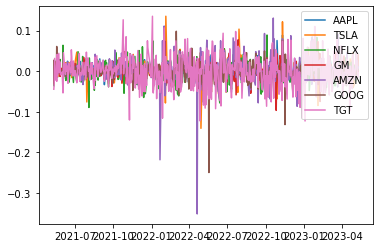

In [2]:
#7 Assets and Historical Data for each asset
assets = ['AAPL', 'TSLA', 'NFLX', 'GM', 'AMZN', 'GOOG', 'TGT'] 
assets_data = yf.download(assets, "2021-5-11", "2023-5-11") ["Adj Close"] 
price = yf.download(assets,
                    period = '2y')['Adj Close'].pct_change()
rets = assets_data.pct_change()
assets_data.dropna(inplace=True)
assets_dataframe = assets_data.head()
al=len(assets)
returns=price

plt.plot(rets)
plt.legend(['AAPL', 'TSLA', 'NFLX', 'GM', 'AMZN', 'GOOG', 'TGT'], loc=1, fontsize=10)


In [3]:
rets.head().dropna()

,AAPL,AMZN,GM,GOOG,NFLX,TGT,TSLA
Date,,,,,,,
2021-05-12,-0.024939,-0.022324,-0.035349,-0.030181,-0.020401,-0.030013,-0.044248
2021-05-13,0.017920,0.003024,0.015625,0.010223,0.003464,0.027838,-0.030853
2021-05-14,0.019845,0.019431,0.025641,0.023957,0.013788,0.012224,0.031573
2021-05-17,-0.009259,0.014735,0.000714,0.002267,-0.008979,-0.005399,-0.021891


In [4]:
#Mean, Variance, Correlation Matrix
returns = assets_data.pct_change()
table_1 = pd.DataFrame(index=assets)
table_1 ['Variance'] = (assets_data.pct_change()*100).var()
table_1 ['Mean'] = returns.mean()

In [5]:
table_1

,Variance,Mean
AAPL,3.542034,0.000835
TSLA,14.527541,0.000332
NFLX,11.395797,-0.000162
GM,6.478891,-0.000699
AMZN,6.699898,-0.000421
GOOG,4.425864,0.000166
TGT,5.309753,-0.000209


In [6]:
returns.corr()

,AAPL,AMZN,GM,GOOG,NFLX,TGT,TSLA
AAPL,1.000000,0.645522,0.501475,0.725014,0.469488,0.466205,0.559427
AMZN,0.645522,1.000000,0.431651,0.696766,0.530612,0.496217,0.479130
GM,0.501475,0.431651,1.000000,0.451492,0.374832,0.412383,0.483644
GOOG,0.725014,0.696766,0.451492,1.000000,0.469325,0.442969,0.449400
NFLX,0.469488,0.530612,0.374832,0.469325,1.000000,0.346345,0.435932
TGT,0.466205,0.496217,0.412383,0.442969,0.346345,1.000000,0.348220
TSLA,0.559427,0.479130,0.483644,0.449400,0.435932,0.348220,1.000000


In [7]:
#Monte Carlo Simulation for Effcient Frontier Calculation
def pR(w):
    return np.sum(returns.mean() * w) * 252
def pV(w):
    return np.sqrt(np.dot(w.T, np.dot(returns.cov() * 252,w)))

retCol = []
volCol = []
wei =[]

for p in range (400000):
    
    weights = np.random.random(al)
    weights /= np.sum(weights)
    
    wei.append(weights)
    
    retCol.append(pR(weights))
    volCol.append(pV(weights))
    
ER = np.array(retCol)
EV = np.array(volCol)

sharpe=(ER-0.02)/EV

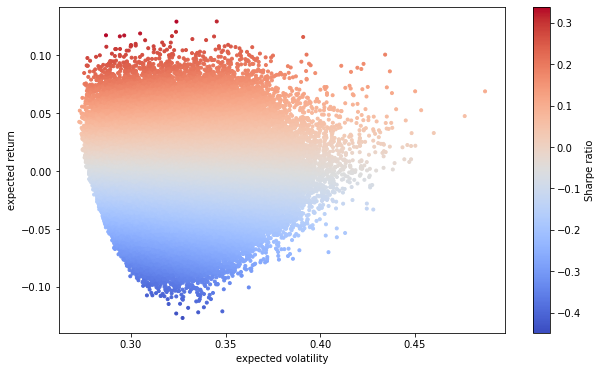

In [8]:
#Simulation Plotted
plt.figure(figsize=(10,6 ))
plt.scatter (EV, ER, c=sharpe,
marker= '.', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

In [9]:
optimalDisplay = pd.DataFrame(columns=['Expected Return','Volatility','Optimal Sharpe Ratio'])
optimalDisplay['Expected Return'] = ER
optimalDisplay['Volatility'] = EV
optimalDisplay['Optimal Sharpe Ratio'] = sharpe

In [10]:
for counter, symbol in enumerate(returns.columns.tolist()):
    optimalDisplay[symbol + " weight"] = [w[counter] for w in wei]

In [11]:
optimalDisplay.set_index("Optimal Sharpe Ratio", inplace=True)
portfolios = pd.DataFrame(optimalDisplay)
optimalDisplayFull = portfolios.head().T
optimalDisplayFull

Optimal Sharpe Ratio,0.113851,0.000625,-0.085617,0.011733,-0.010395
Expected Return,0.057837,0.020205,-0.005367,0.023872,0.016834
Volatility,0.332342,0.328631,0.296284,0.329974,0.304562
AAPL weight,0.298758,0.162784,0.213786,0.158356,0.218616
AMZN weight,0.109887,0.129848,0.150210,0.119136,0.135070
GM weight,0.002199,0.110686,0.193942,0.038569,0.178267
GOOG weight,0.013372,0.214173,0.086787,0.215484,0.297048
NFLX weight,0.102353,0.119842,0.027453,0.214983,0.081177
TGT weight,0.212264,0.049639,0.221216,0.083681,0.000139
TSLA weight,0.261168,0.213028,0.106606,0.169791,0.089682


In [13]:
#Linear Regression to calculate Efficient Frontier
def sharpeM(w):
    return - (pR(w)-0.02)/pV(w)

constraints = ({'type': 'eq','fun':lambda x: np.sum(x)-1})
bounds = tuple((0,1) for x in range(al))
weightVolumen = np.array(al*[1. /al,])
sharpeM(weightVolumen)

0.08198432256602019

In [14]:
sharpeOptimized = sco.minimize(sharpeM,
                               weightVolumen,
                               method='SLSQP',
                               bounds= bounds,
                               constraints=constraints)

In [16]:
volumenOptimized = sco.minimize(pV,
                                weightVolumen,
                                method='SLSQP',
                                bounds=bounds,
                                constraints=constraints)

In [22]:
constraintsLinearRegresion = ({'type': 'eq', 'fun': lambda x: pR(x)-tReturn},
                             {'type':'eq','fun': lambda x: np.sum(x)-1})
boundsLinearRegresion = tuple((0,1) for x in weights)

tReturns = np.linspace(0.05,0.2,50)
tVolatility = []

In [23]:
for tReturn in tReturns:
    result = sco.minimize(pV,
                          weightVolumen,
                          method = 'SLSQP',
                          bounds= boundsLinearRegresion,
                          constraints=constraintsLinearRegresion)
    tVolatility.append(result['fun'])
tVolatility = np.array(tVolatility)

In [25]:
optimalPortfolioReturn = pR(sharpeOptimized['x'])
optimalPortfolioReturn.round(4)

0.2104

In [26]:
optimalPortfolioVolatilityWeight = pV(sharpeOptimized['x'])
optimalPortfolioVolatilityWeight.round(4)

0.2988

In [27]:
sharpeRatioMaximized = (optimalPortfolioReturn-0.02)/optimalPortfolioVolatilityWeight
sharpeRatioMaximized.round(4)

0.6374

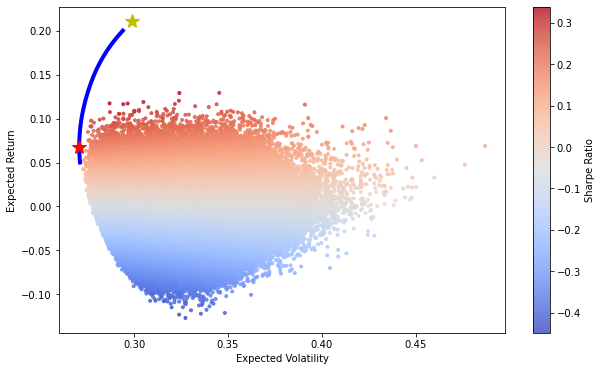

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(EV, ER, c=sharpe,marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tVolatility, tReturns, 'b', lw=4.0)

plt.plot(pV(sharpeOptimized['x']), 
         pR(sharpeOptimized['x']),
         'y*', markersize = 15.0)
plt.plot(pV(volumenOptimized['x']), 
         pR(volumenOptimized['x']),
         'r*', markersize=15.0)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')

In [ ]:
# Citation
- Credit given to Professor John Droescher 
- Hilpisch, Y. (2015). Python for finance. O'Reilly Media. 
- https://medium.com/python-data/efficient-frontier-portfolio-optimization-with-python-part-2-2-2fe23413ad94
- https://www.learnpythonwithrune.org/monte-carlo-simulation-to-optimize-a-portfolio-using-pandas-and-numpy/